<a href="https://colab.research.google.com/github/marlonrcfranco/weather-guru/blob/main/weather_guru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# weather-guru
## Will it rain tomorrow?


### Goal 🌦
Implement an algorithm that performs **next day rain prediction** by training machine learning models on the target variable `RainTomorrow`.



### Dataset 📂
The dataset contains about **10 years of daily weather observations** from various locations in **Australia**.

**`RainTomorrow`** is the target variable to be  predicted. It means - it rained the next day, this column is `Yes` if the rain that day was 1mm or more.







## Imports & Defines

In [87]:
%matplotlib inline
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, accuracy_score
from tensorflow.keras.layers import LSTM, Dense, Input, TimeDistributed, Masking
from tensorflow.keras.models import Model, Sequential, model_from_json
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

DATASET_URL = "https://raw.githubusercontent.com/marlonrcfranco/weather-guru/main/data/weatherAUS.csv"
EPOCHS = 100
BATCH_SIZE = 77
TRAIN_SPLIT = 0.87
LOSS_FUNCTION = 'mse' # 'mse': Mean Square Error, 'mae': Mean Absolute Error, 'binary_crossentropy'
LEARNING_RATE = 0.001 #0.001
NEURONS = 128


## Fetch Data

In [2]:
weather_df = pd.read_csv(DATASET_URL,parse_dates=True)
# Dataset is now stored in a Pandas Dataframe

## Data Visualization

### Data Info

In [4]:
weather_df.info()
# 145460 rows, 22 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

### Sample

In [5]:
weather_df.sample()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
60148,2014-08-27,Bendigo,2.8,19.9,0.0,NaN,NaN,SW,26.0,NaN,SW,0.0,15.0,74.0,49.0,1028.5,1026.4,NaN,4.0,13.6,19.1,No,No


### Unique values

In [6]:
for col in weather_df:
    print("\n[" + col + "]:")
    print(weather_df[col].unique())


[Date]:
['2008-12-01' '2008-12-02' '2008-12-03' ... '2008-01-29' '2008-01-30'
 '2008-01-31']

[Location]:
['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']

[MinTemp]:
[13.4  7.4 12.9  9.2 17.5 14.6 14.3  7.7  9.7 13.1 15.9 12.6  8.4  9.8
 14.1 13.5 11.2 11.5 17.1 20.5 15.3 16.2 16.9 20.1 19.7 12.5 12.  11.3
  9.6 10.5 12.3 13.7 16.1 14.  17.  17.3 17.2 17.4 19.8 14.9 13.9 18.6
 19.3 24.4 18.8 20.8 15.7 18.5 20.4 21.8 22.3 22.  28.  21.5 21.7 23.5
 28.3 18.4 12.4 

### Histograms

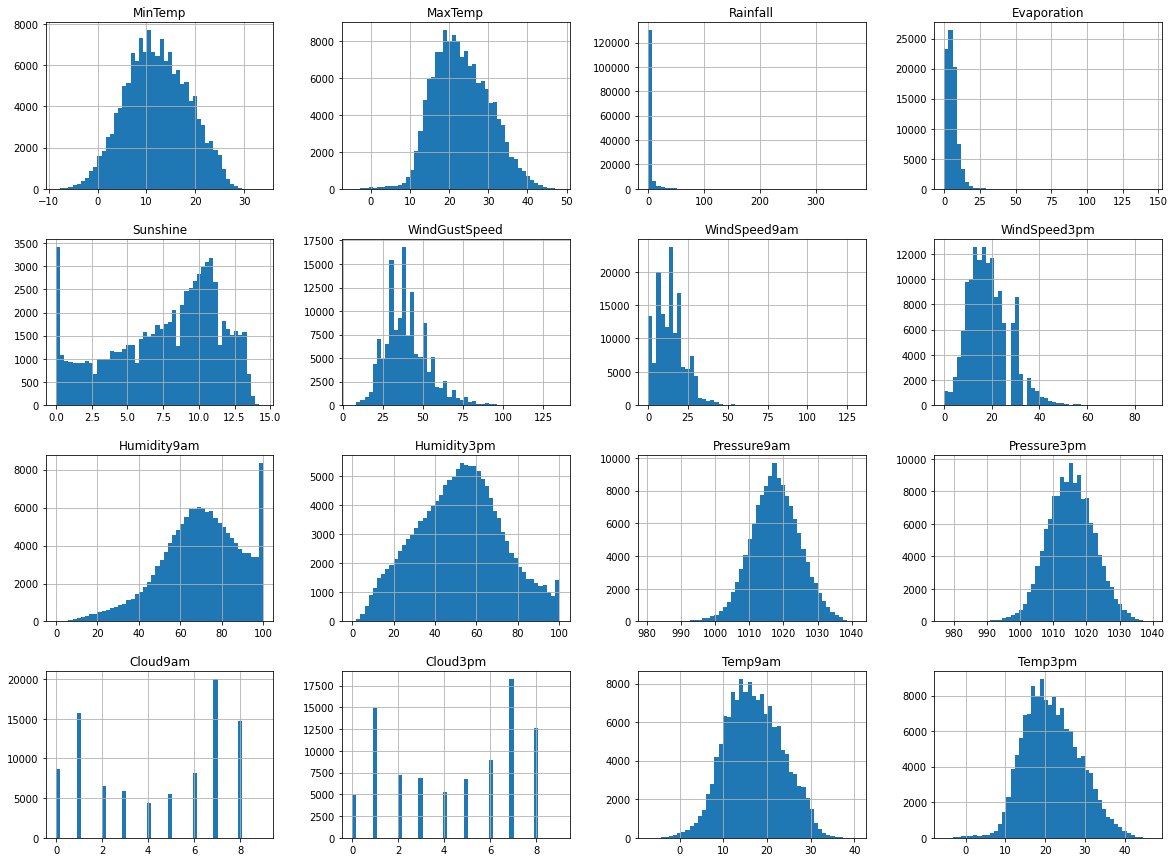

In [7]:
weather_df.hist(bins=50, figsize=(20,15))
plt.show()

### Correlation

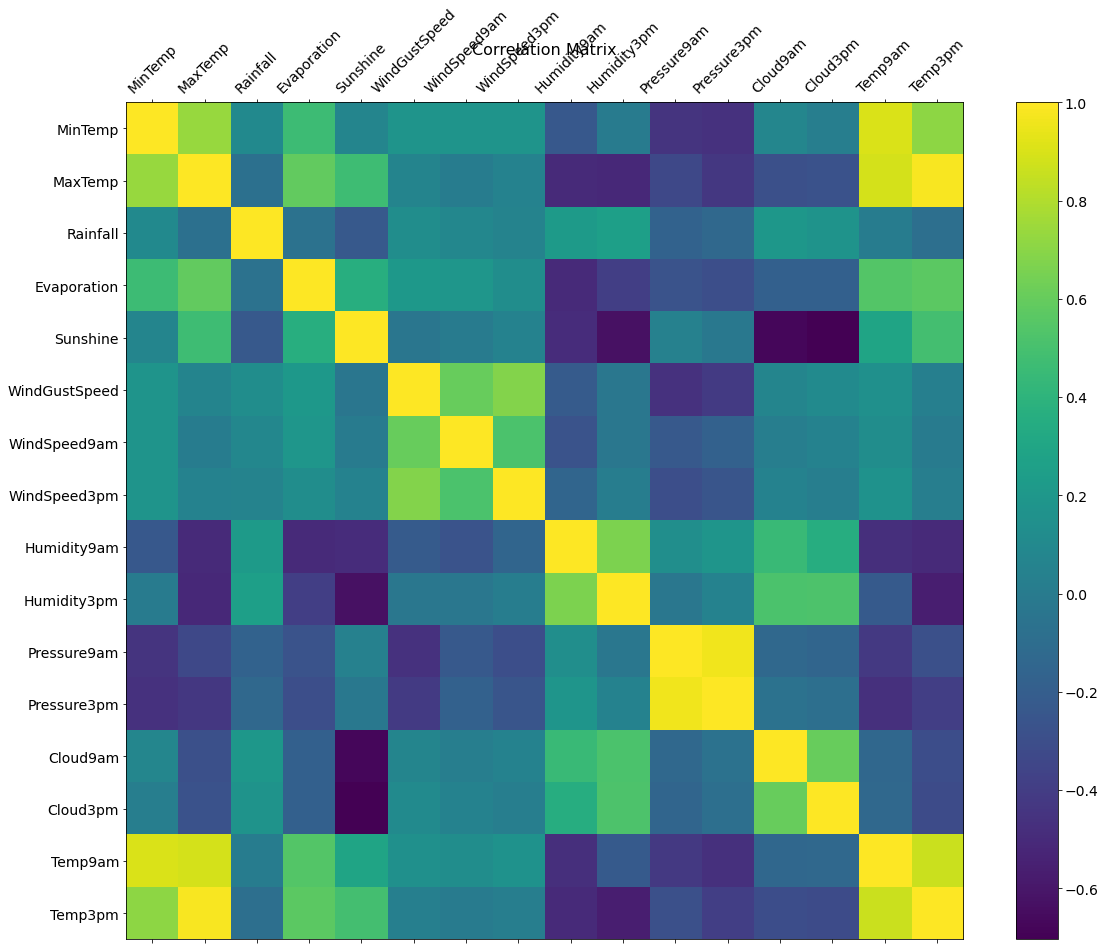

In [8]:
f = plt.figure(figsize=(19, 15))
plt.matshow(weather_df.corr(), fignum=f.number)
plt.xticks(range(weather_df.select_dtypes(['number']).shape[1]), weather_df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(weather_df.select_dtypes(['number']).shape[1]), weather_df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

## Data pre-processing

### Ignore rows with null values in the target column

In [9]:
# There are null values (nan) in the RainTomorrow column
print("Before:\n Unique values in the RainTomorrow column: " + str(weather_df.RainTomorrow.unique()))
rows_before = len(weather_df)
print(" Total number of rows: " + str(rows_before))

Before:
 Unique values in the RainTomorrow column: ['No' 'Yes' nan]
 Total number of rows: 145460


In [10]:
# Select only the not-null rows
weather_df = weather_df[weather_df.RainTomorrow.notna()]

print("After:\n Unique values in the RainTomorrow column: " + str(weather_df.RainTomorrow.unique()))
rows_after = len(weather_df)
print(" Total number of rows: " + str(rows_after) + " (" + str(rows_before-rows_after) +  " rows ignored)")

After:
 Unique values in the RainTomorrow column: ['No' 'Yes']
 Total number of rows: 142193 (3267 rows ignored)


### Convert Data Types

In [11]:
# Map 'Yes' and 'No' to True and False to infer boolean values
weather_df.RainToday = weather_df.RainToday.map(dict(Yes=True, No=False))
weather_df.RainTomorrow = weather_df.RainTomorrow.map(dict(Yes=True, No=False))

# Convert data types
weather_df['Date'] = pd.to_datetime(weather_df['Date'])
weather_df = weather_df.convert_dtypes()

# Visualize new data types
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142193 entries, 0 to 145458
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           142193 non-null  datetime64[ns]
 1   Location       142193 non-null  string        
 2   MinTemp        141556 non-null  float64       
 3   MaxTemp        141871 non-null  float64       
 4   Rainfall       140787 non-null  float64       
 5   Evaporation    81350 non-null   float64       
 6   Sunshine       74377 non-null   float64       
 7   WindGustDir    132863 non-null  string        
 8   WindGustSpeed  132923 non-null  Int64         
 9   WindDir9am     132180 non-null  string        
 10  WindDir3pm     138415 non-null  string        
 11  WindSpeed9am   140845 non-null  Int64         
 12  WindSpeed3pm   139563 non-null  Int64         
 13  Humidity9am    140419 non-null  Int64         
 14  Humidity3pm    138583 non-null  Int64         
 15  

### Add YEAR, MONTH and DAY columns

In [12]:
weather_df['YEAR'] = weather_df.Date.dt.year
weather_df['MONTH'] = weather_df.Date.dt.month
weather_df['DAY'] = weather_df.Date.dt.day
weather_df.set_index(keys=['Date','YEAR','MONTH','DAY'], inplace=True)

weather_df.sample()

,,,,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
Date,YEAR,MONTH,DAY,,,,,,,,,,,,,,,,,,,,,,
2015-03-11,2015,3,11,PearceRAAF,13.5,36.3,0.0,NaN,11.6,ESE,37,ESE,SSE,19,7,50,20,1015.8,1012.2,0,0,25.4,35.2,False,False


### Add Latitude and Longitude columns (WARNING this might take a while)

In [ ]:
locator = Nominatim(user_agent="weather-guru")
# conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)

# 1 - List the unique values of Location, to further improve performance
unique_locations = pd.DataFrame()
unique_locations['Location'] = weather_df['Location'].unique()
# Separate CamelCase with space to allow geocode to find the location
unique_locations['Location'] = unique_locations['Location'].apply(lambda loc: re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', loc)))
# Add the country to the Location in order to avoid misunderstandings
unique_locations['Location'] = unique_locations['Location'].apply(lambda loc: loc + ', Australia')

# 2- create improved location column (gcode)
print("Searching for locations...")
unique_locations['gcode'] =  unique_locations['Location'].apply(geocode)

# 3 - create point (longitude, latitude and altitude) from gcode (location) column (returns tuple)
unique_locations['point'] = unique_locations['gcode'].apply(lambda loc: tuple(loc.point) if loc else None)

# 4 - split point column into latitude, longitude and altitude columns
unique_locations[['latitude', 'longitude', 'altitude']] = pd.DataFrame(unique_locations['point'].tolist(), index=unique_locations.index)

if not unique_locations['gcode'].isnull().any(): 
  print("All the locations were found!")
else: 
  print("The current places were not found:")
  print(unique_locations[unique_locations['gcode'].isnull()])

# 5 - drop temporary columns
#weather_df['gcode'].drop()
#weather_df['point'].drop()


Searching for locations...


In [86]:
if unique_locations['gcode'].str.contains(' Australia').all():
  print('All the places found are from Australia')

All the places found are from Australia


In [ ]:
# Save processed dataframe
weather_df.to_csv(ROOT_PATH+'new_weather_dataset.csv')

In [ ]:
#locator = Nominatim(user_agent="weather-guru")
#location = locator.geocode("Adelaide")
#print(location)

### Integer encode direction

In [ ]:
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

### Ensure all data is float

In [ ]:
values = weather_df.values
values = values.astype('float32')

### Normalize features

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

## Design network

In [ ]:
model = Sequential()
model.add(LSTM(NEURONS, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True, name='lstm1'))
model.add(LSTM(NEURONS, name='lstm2'))
model.add(Dense(1, activation='linear', name='output'))
optimizer = Adam(lr=LEARNING_RATE)
model.compile(loss=LOSS_FUNCTION, optimizer=optimizer)
model.summary()

## Training

To be Continued...